# Alertness & Sleep‑Stage Pipeline v4 – Metrics + Transition Logic
Builds on v3 by adding:
* Full **multi‑class sleep‑stage classifier** (Deep / REM / Light / Wake).
* Temporal logic -> stable stage output after N consecutive votes.
* Probability of stage change & alertness score in one unified dataframe.
* Rigorous metrics: ROC‑AUC (OvR), confusion matrices, F1, plus plots.


In [19]:

import os, pickle, warnings, math
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy as scipy_entropy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, f1_score, precision_score, recall_score)
from sklearn.model_selection import GroupKFold, cross_val_score
import mne
sns.set(style='whitegrid'); warnings.filterwarnings('ignore')


In [2]:

DATA_ROOT = Path('sample_data')
FS = 125; EPOCH_SEC = 30; MIN_GOOD_RATIO = 0.6
TRAIN_POS, TRAIN_NEG = 'Wake','Deep'
STAGES = ['Deep','REM','Light','Wake']
BANDS={'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}
CHANNEL_VARIANTS={'all':[0,1,2,3],'frontal':[0,2],'rf_only':[2]}


In [3]:

def bandpass(x, low=0.5, high=45, order=4):
    b,a = butter(order, [low/(0.5*FS), high/(0.5*FS)], btype='band')
    return filtfilt(b,a,x,axis=-1)

def hjorth_params(sig):
    act=np.var(sig); diff=np.diff(sig)
    mob=np.sqrt(np.var(diff)/act) if act else 0
    diff2=np.diff(diff)
    comp=np.sqrt(np.var(diff2)/np.var(diff)) if np.var(diff) else 0
    return act,mob,comp

def spectral_entropy(sig):
    f,P=welch(sig, fs=FS, nperseg=min(len(sig),4*FS))
    P_norm=P/np.sum(P) if np.sum(P) else P
    return scipy_entropy(P_norm, base=2)

def epoch_features(epoch):
    fdict={}
    for ch in range(epoch.shape[0]):
        sig=epoch[ch]
        fdict[f'ch{ch}_mean']=sig.mean()
        fdict[f'ch{ch}_std']=sig.std()
        a,mob,com=hjorth_params(sig)
        fdict[f'ch{ch}_activity']=a; fdict[f'ch{ch}_mobility']=mob; fdict[f'ch{ch}_complexity']=com
        fdict[f'ch{ch}_spec_entropy']=spectral_entropy(sig)
        f,P=welch(sig, fs=FS, nperseg=min(len(sig),4*FS))
        total=np.trapz(P,f)
        for band,(lo,hi) in BANDS.items():
            idx=(f>=lo)&(f<hi); power=np.trapz(P[idx],f[idx])
            fdict[f'ch{ch}_{band}_rel']=power/total if total else 0
    return fdict


In [4]:

def build_epochs(rec_dir):
    edf=next(rec_dir.glob('*.edf')); stage_csv=next(rec_dir.glob('*[0-9].csv'))
    sqc_csv=next(rec_dir.glob('*SQC.csv'))
    raw=mne.io.read_raw_edf(edf, preload=True, verbose=False)
    raw.filter(0.5,45, fir_design='firwin', verbose=False)
    data=bandpass(raw.get_data()[:4])
    df_stage=pd.read_csv(stage_csv); df_sqc=pd.read_csv(sqc_csv)
    start_ts=df_stage['Timestamp'].min()
    rows=[]
    for _,row in df_stage.iterrows():
        ts=row['Timestamp']; lbl=row['Sleep stage']
        st=int((ts-start_ts)*FS); en=st+EPOCH_SEC*FS
        if en>data.shape[1]: break
        mask=(df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        good_ratio=(df_sqc.loc[mask,'Signal quality']=='Good').mean()
        if good_ratio<MIN_GOOD_RATIO: continue
        feats=epoch_features(data[:,st:en])
        feats.update({'good_ratio':good_ratio,'stage':lbl,'record':rec_dir.name})
        rows.append(feats)
    return pd.DataFrame(rows)


In [5]:

rec_dirs=[p for p in DATA_ROOT.iterdir() if p.is_dir()]
if not rec_dirs: raise FileNotFoundError('sample_data missing.')
base_df=pd.concat([build_epochs(p) for p in rec_dirs], ignore_index=True)
print('Epochs:', base_df.shape)


Epochs: (16088, 47)


In [6]:

chosen_variant='frontal'
ch_idx=CHANNEL_VARIANTS[chosen_variant]
cols=[c for c in base_df.columns if c.startswith(tuple([f'ch{i}_' for i in ch_idx]))]+['good_ratio']
print('Using columns:', len(cols))


Using columns: 23


In [8]:

alert_df=base_df[base_df['stage'].isin([TRAIN_POS,TRAIN_NEG])].copy()
alert_df['y']=(alert_df['stage']==TRAIN_POS).astype(int)
X_alert=alert_df[cols]; y_alert=alert_df['y']; groups=alert_df['record']
pipe_alert=Pipeline([('imp',SimpleImputer(strategy='median')),
                     ('sc',StandardScaler(with_mean=False)),
                     ('clf',LogisticRegression(max_iter=1200))])
auc = cross_val_score(pipe_alert, X_alert, y_alert,
                     cv=GroupKFold(n_splits=5).split(X_alert, y_alert, groups),
                     scoring='roc_auc').mean()
pipe_alert.fit(X_alert,y_alert)
print(f'Alertness model AUC={auc:.3f}')


Alertness model AUC=0.806


In [9]:

stage_df=base_df.copy()
X_stage=stage_df[cols]; y_stage=stage_df['stage']; grp=stage_df['record']
clf_stage=HistGradientBoostingClassifier()
pipe_stage=Pipeline([('imp',SimpleImputer(strategy='median')),('clf',clf_stage)])
acc=cross_val_score(pipe_stage,X_stage,y_stage,
                    cv=GroupKFold(n_splits=5).split(X_stage,y_stage,grp),
                    scoring='accuracy').mean()
pipe_stage.fit(X_stage,y_stage)
print('Stage classifier CV accuracy:', round(acc,3))


Stage classifier CV accuracy: 0.625


Macro AUC: 0.743
Macro F1: 0.527
Macro Precision: 0.8
Macro Recall: 0.471
Classification Report:
               precision    recall  f1-score   support

        Deep       0.76      0.58      0.66      3936
         REM       0.70      0.31      0.43      2257
       Light       0.69      0.90      0.78      8799
        Wake       0.85      0.48      0.61      1084

   micro avg       0.71      0.71      0.71     16076
   macro avg       0.75      0.57      0.62     16076
weighted avg       0.72      0.71      0.69     16076



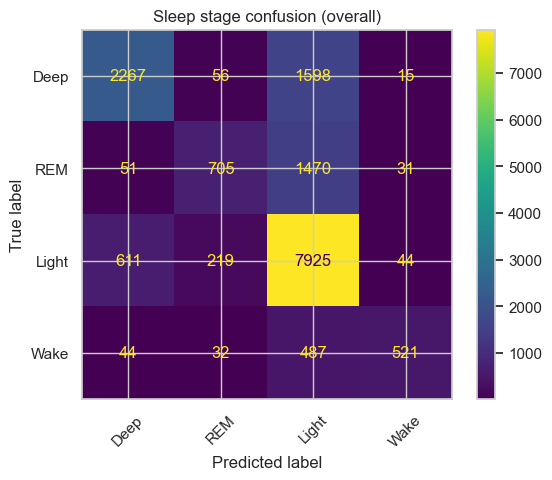

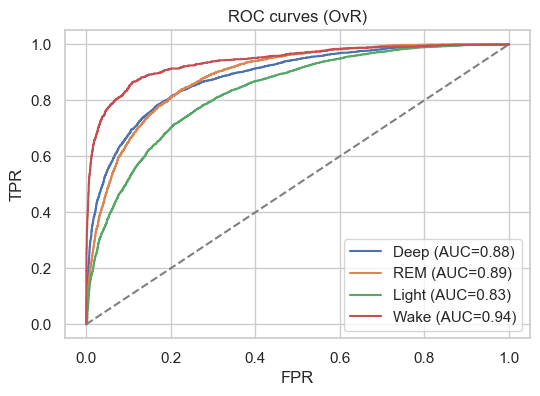

In [20]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
lb=LabelBinarizer(); y_bin=lb.fit_transform(y_stage)
probs=pipe_stage.predict_proba(X_stage)
fpr,tpr,roc_auc={}, {}, {}
for i,cls in enumerate(lb.classes_):
    fpr[cls],tpr[cls],_ = roc_curve(y_bin[:,i], probs[:,i])
    roc_auc[cls]=auc(fpr[cls],tpr[cls])
# Macro
macro_auc=roc_auc_score(y_bin, probs, average='macro')
y_pred = pipe_stage.predict(X_stage)
macro_f1 = f1_score(y_stage, y_pred, average='macro')
macro_precision = precision_score(y_stage, y_pred, average='macro')
macro_recall = recall_score(y_stage, y_pred, average='macro')
report = classification_report(y_stage, y_pred, labels=STAGES)
print('Macro AUC:', round(macro_auc,3))
print('Macro F1:', round(macro_f1,3))
print('Macro Precision:', round(macro_precision,3))
print('Macro Recall:', round(macro_recall,3))
print('Classification Report:\n', report)

cm=confusion_matrix(y_stage, y_pred, labels=STAGES)
disp=ConfusionMatrixDisplay(cm, display_labels=STAGES)
disp.plot(xticks_rotation=45); plt.title('Sleep stage confusion (overall)'); plt.show()

plt.figure(figsize=(6,4))
for cls in STAGES:
    plt.plot(fpr[cls], tpr[cls], label=f'{cls} (AUC={roc_auc[cls]:.2f})')
plt.plot([0,1],[0,1],'--',color='grey'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC curves (OvR)'); plt.legend(); plt.grid(True); plt.show()


AUC (Wake vs Deep) — Raw: 0.876, Smooth: 0.897
Spearman Corr — Raw vs Stage: nan, Smooth vs Stage: nan
MSE — Raw: 1.352, Smooth: 1.549


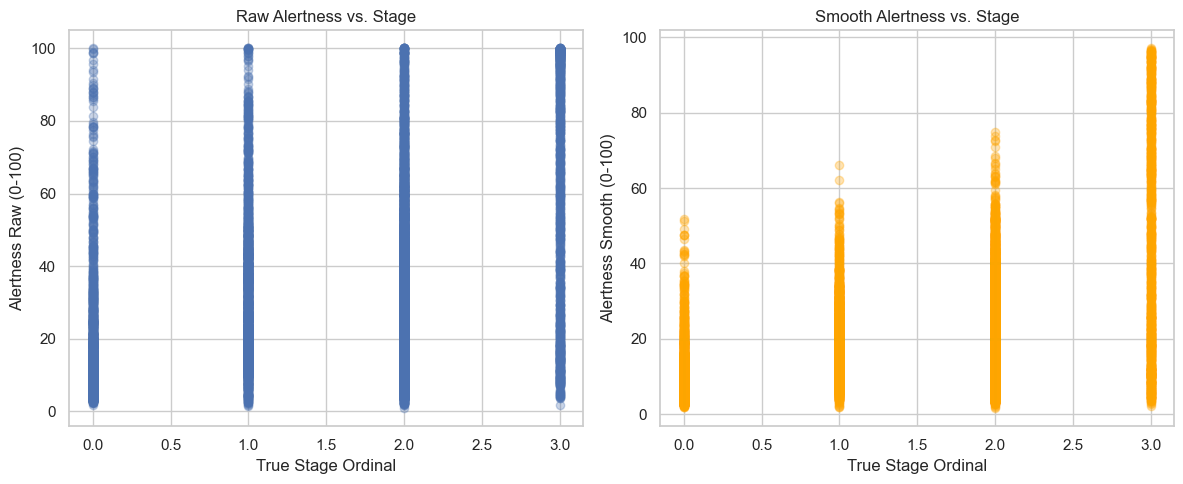

In [ ]:

# --- Deep performance evaluation of alertness vs. sleep stage ---

from sklearn.metrics import roc_auc_score, mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Map stages to ordinal values
stage_map = {'Deep':0, 'REM':1, 'Light':2, 'Wake':3}
ordinals = epochs['stage'].map(stage_map)

# Raw and smooth alertness probabilities
raw_prob = epochs['alert_raw'] / 100
smooth_prob = epochs['alert_smooth'] / 100

# Binary mask for Wake vs Deep
mask_wd = epochs['stage'].isin(['Deep','Wake'])
y_wd = (epochs.loc[mask_wd, 'stage'] == 'Wake').astype(int)

# AUC comparison
auc_raw = roc_auc_score(y_wd, raw_prob[mask_wd])
auc_smooth = roc_auc_score(y_wd, smooth_prob[mask_wd])
print(f'AUC (Wake vs Deep) — Raw: {auc_raw:.3f}, Smooth: {auc_smooth:.3f}')

# Spearman correlation with stage ordinal
corr_raw, _ = spearmanr(epochs['alert_raw'], ordinals)
corr_smooth, _ = spearmanr(epochs['alert_smooth'], ordinals)
print(f'Spearman Corr — Raw vs Stage: {corr_raw:.3f}, Smooth vs Stage: {corr_smooth:.3f}')

# MSE for ordinal prediction
mse_mask = ~ordinals.isna()
mse_raw = mean_squared_error(ordinals[mse_mask], (epochs.loc[mse_mask, 'alert_raw']/100*3))
mse_smooth = mean_squared_error(ordinals[mse_mask], (epochs.loc[mse_mask, 'alert_smooth']/100*3))
print(f'MSE — Raw: {mse_raw:.3f}, Smooth: {mse_smooth:.3f}')

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(ordinals, epochs['alert_raw'], alpha=0.3)
axes[0].set_xlabel('True Stage Ordinal')
axes[0].set_ylabel('Alertness Raw (0-100)')
axes[0].set_title('Raw Alertness vs. Stage')
axes[1].scatter(ordinals, epochs['alert_smooth'], alpha=0.3, color='orange')
axes[1].set_xlabel('True Stage Ordinal')
axes[1].set_ylabel('Alertness Smooth (0-100)')
axes[1].set_title('Smooth Alertness vs. Stage')
plt.tight_layout()
plt.show()


In [12]:

def smooth(series, window=3):
    return pd.Series(series).rolling(window, min_periods=1).mean().values

def stage_logic(pred_probs, base_thresh=0.6, stable_n=2):
    # pred_probs shape (n_samples, n_classes)
    preds=np.argmax(pred_probs, axis=1)
    out=[]; stable_count=0; current=preds[0]
    for i,p in enumerate(preds):
        if p==current:
            stable_count+=1
        else:
            if np.max(pred_probs[i])>=base_thresh:
                stable_count=1; current=p
            else:
                p=current
        if stable_count<stable_n:
            p=current
        out.append(p)
    return np.array(out)

# Apply to full df
base_df['alert_raw']=pipe_alert.predict_proba(base_df[cols])[:,1]*100
base_df['alert_smooth']=smooth(base_df['alert_raw'])
stage_probs=pipe_stage.predict_proba(base_df[cols])
base_df['stage_pred_raw']=pipe_stage.classes_[np.argmax(stage_probs,axis=1)]
stable_idx=stage_logic(stage_probs)
base_df['stage_stable']=pipe_stage.classes_[stable_idx]
# probability of change = 1 - prob(current stable)
prob_current=stage_probs[np.arange(len(stage_probs)), stable_idx]
base_df['prob_change']=1-prob_current


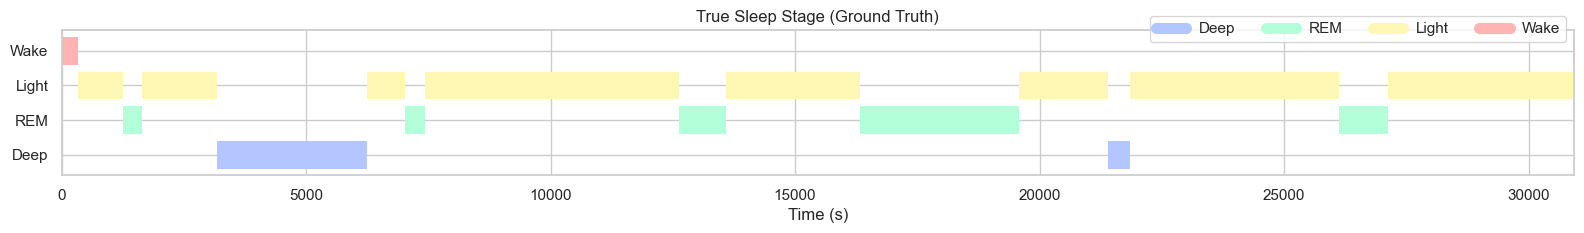

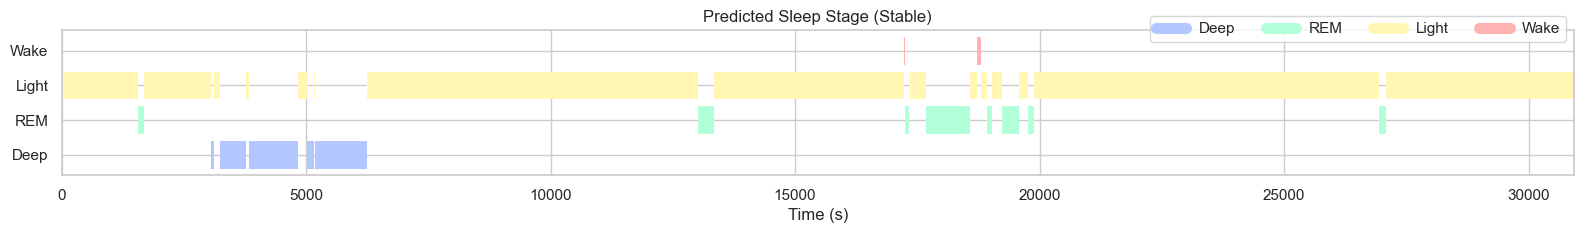

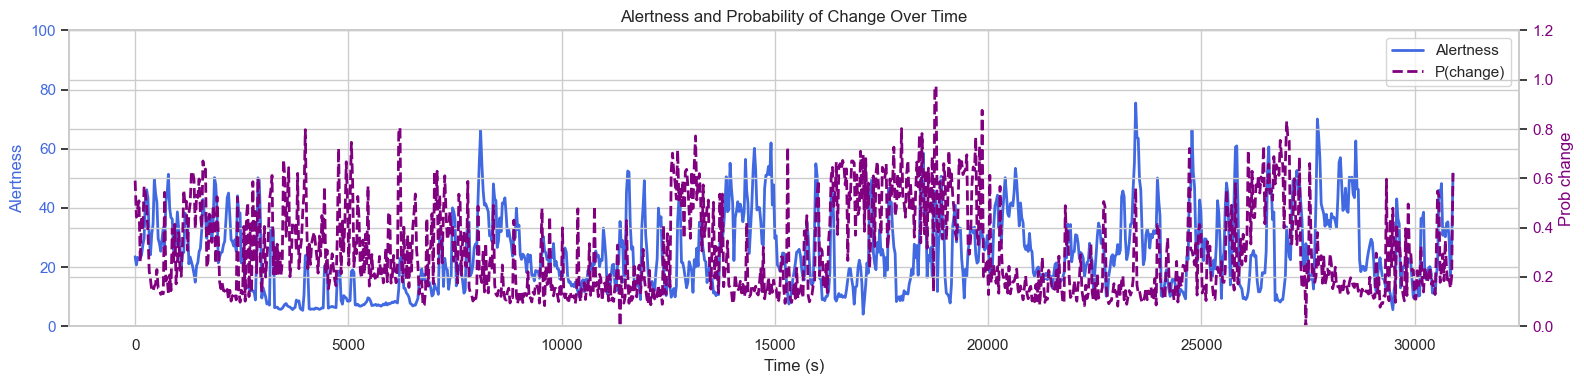

In [18]:
import matplotlib.patches as mpatches

stage_colors = {'Deep': '#b3c6ff', 'REM': '#b3ffd9', 'Light': '#fff7b3', 'Wake': '#ffb3b3'}
stage_y = {stage: i for i, stage in enumerate(STAGES)}
rec = base_df['record'].iloc[0]
sample = base_df[base_df['record'] == rec].reset_index(drop=True)
t = np.arange(len(sample)) * EPOCH_SEC

# --- Plot 1: True sleep stage timeline (categorical y-axis, horizontal bars) ---
fig, ax = plt.subplots(figsize=(16, 2.5))
for stage in STAGES:
    m = sample['stage'] == stage
    for x in t[m]:
        ax.barh(stage, EPOCH_SEC, left=x, color=stage_colors[stage], align='center', edgecolor='none')
ax.set_xlabel('Time (s)')
ax.set_xlim(t[0], t[-1] + EPOCH_SEC)
ax.set_yticks(STAGES)
ax.set_title('True Sleep Stage (Ground Truth)')
handles = [plt.Line2D([0], [0], color=clr, lw=8) for clr in stage_colors.values()]
ax.legend(handles, STAGES, ncol=4, bbox_to_anchor=(1.0, 1.15))
plt.tight_layout()
plt.show()

# --- Plot 2: Predicted sleep stage timeline (categorical y-axis, horizontal bars) ---
fig, ax = plt.subplots(figsize=(16, 2.5))
for stage in STAGES:
    m = sample['stage_stable'] == stage
    for x in t[m]:
        ax.barh(stage, EPOCH_SEC, left=x, color=stage_colors[stage], align='center', edgecolor='none')
ax.set_xlabel('Time (s)')
ax.set_xlim(t[0], t[-1] + EPOCH_SEC)
ax.set_yticks(STAGES)
ax.set_title('Predicted Sleep Stage (Stable)')
handles = [plt.Line2D([0], [0], color=clr, lw=8) for clr in stage_colors.values()]
ax.legend(handles, STAGES, ncol=4, bbox_to_anchor=(1.0, 1.15))
plt.tight_layout()
plt.show()

# --- Plot 3: Alertness and probability of change ---
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(t, sample['alert_smooth'], label='Alertness', color='royalblue', linewidth=2)
ax1.set_ylabel('Alertness', color='royalblue')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='y', labelcolor='royalblue')
ax2 = ax1.twinx()
ax2.plot(t, sample['prob_change'], label='P(change)', color='purple', linestyle='--', linewidth=2)
ax2.set_ylabel('Prob change', color='purple')
ax2.set_ylim(0, 1.2)
ax2.tick_params(axis='y', labelcolor='purple')
ax1.set_xlabel('Time (s)')
ax1.set_title('Alertness and Probability of Change Over Time')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:

with open('alertness_model.pkl','wb') as f: pickle.dump(pipe_alert,f)
with open('stage_classifier.pkl','wb') as f: pickle.dump(pipe_stage,f)
print('Saved models.')

Saved models.
